<img src="MatchBrand%20symbol.png" alt="MatchBrand Symbol">


# **Topic Modelling with K-Means Clustering**

Our first attempt with Topic Modelling is with K-Means Clustering as it is simple and intuitive to understand. It is also fast, even on large datasets. As the algorithm works by iteratively assigning data points to the cluster with the nearest mean, and then updating the cluster means based on the data points that have been assigned to them, the challenge might be that the **semantic meaning** is not taken into account, as it works purely on a numerical basis. To address this challenge, we leveraged different methods to capture the semantics of our data. These methods, when combined with the K-means approach will allow us to make the most out of the numerical efficiency of out text data.

Specifically for the approach with K-means, we tested with the following text representation methods:

* **Word2Vec**

* **Doc2Vec**

* **BERT**

The K-means implementation is divided into three main parts:

* **Topic Modelling: Job Postings**
* **Topic Modelling: Instagram Profiles**
* **Matching Instagram profiles with job postings**

For each dataset, we carried out the following steps:

1. **Find the Optimal Number of Clusters**: An optimal number of clusters needs to be determined for the K-means. To accomplish this, we leverage methods like the Elbow method.

2. **Assigning Cluster Labels**: After determining the optimal number of clusters, each cluster is assigned a label. For this, we examine each cluster with different methods to label the topics, such as WordCloud, Cluster centroids and even manually examining.
These labels should be relevant to the matching task and provide us with insights that can be used for further analysis and tasks.

Finally, DistilBERT is used to transform the clusters into embeddings, and cosine similarity is computed to find the best match between Instagram topics and job topics. The use of DistilBERT is justified in this context because the topic text is relatively small and doesn't necessitate a more complex transformer like BERT. For this task, DistilBERT can work quickly and efficiently.

As for the matching score, we use the embeddings from DistilBERT to compute cosine similarity as the primary factor of our final score. Furthermore, we use the proportion of posts per Instagram profile in each cluster as a factor in our matching score.

# Implementation

## A. Load Libraries

In [1]:
''' 
# Install pip packages if not done in alphabetical order to avoid duplicates
!pip install gensim
!pip3 install scikit-learn
!pip install sentence-transformers
!pip install torch
!pip install transformers
'''

' \n# Install pip packages if not done in alphabetical order to avoid duplicates\n!pip install gensim\n!pip3 install scikit-learn\n!pip install torch\n!pip install transformers\n'

In [2]:
# Import packages in alphabetical order to avoid duplicates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import gensim

# Import packages in alphabetical order to avoid duplicates
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertModel, DistilBertTokenizer
from typing import List, Tuple
from wordcloud import WordCloud

c:\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Read pickle files
df_translated_insta = pd.read_pickle('Datasets/df_translated_instagram.pkl')
df_translated_job = pd.read_pickle('Datasets/df_translated_job.pkl')

## B. Text Representation

In Text Representation, we aim to capture semantic meaning in the text. Therefore, text representation methods with embeddings are preferred, such as Word2Vec, Doc2Vec and DistilBERT.

When choosing an appropriate method, there are a few points needed to be taken into account:

- There are certain circumstances where using Word2Vec might be preferable. It is efficient and fast, understandable and interpretable as it creates vector representations in lower-dimensional space. However, it does not consider word orders, which can lead to loss of context. Word2Vec is designed to produce embeddings at word level, not document level.

- Unlike Word2Vec, Doc2Vec can solve this problem, capturing the overall context better.

- When dealing with Instagram data and Job postings, we deal with rather shorter texts and more informal language. Therefore, we might consider Word2Vec with Averaging because semantic meaning on document level is not as important.

- BERT is known for state-of-the-art performance in many NLP tasks. For simple data like Instagram data or Job postings data, BERT might be an overkill. It is also computational exhaustive. For this reason we chose to use DistilBERT, a lighterweight version of BERT, retaining 95% of the performance for only half of the parameters and encoders (6 instead of 12).

Although Word2Vec and Doc2Vec can provide a good enough representation for simple tasks like understanding topics in the data, DistilBERT is still better at capturing the context and semantic meanings, and might pair well with the K-means clustering. After several tests, we decided to choose DistilBERT in this approach, as it produced the most meaningful clusters.

### Word2Vec with Averaging
Average document-level word embeddings using averaged Word2Vec could be an alternative to DistilBERT which could be used to directly calculate the cosine similarity between the two datasets without topic modelling.

In [4]:
# Define a function to generate document-level word embeddings
def generate_average_doc_representation(corpus: List[List[str]], min_word_count: int):
    # Train Word2Vec model
    model = Word2Vec(corpus, vector_size=100, min_count=min_word_count)

    # Generate document-level word embeddings
    corpus_w2v = [[model.wv[word] for word in doc if word in model.wv.key_to_index.keys()] for doc in corpus]

    # Get indices of non-empty documents (documents with at least one word in the model's vocabulary)
    positive_indices = [i for i in range(len(corpus)) if len(corpus_w2v[i]) > 0]

    # Filter out empty documents
    corpus_w2v = [corpus_w2v[i] for i in positive_indices]

    # Average document representation
    corpus_w2v_avg = [sum(words) / len(words) for words in corpus_w2v]

    return corpus_w2v_avg, positive_indices

# Apply the function to df_job_lemma and df_insta_lemma
corpus_w2v_avg_job, positive_indices_job = generate_average_doc_representation(df_translated_job['Merged'], 10)
corpus_w2v_avg_insta, positive_indices_insta = generate_average_doc_representation(df_translated_insta['caption'], 10)

### Doc2Vec

In [5]:
# Define a function to train a Doc2Vec model
def train_doc2vec(corpus: List[List[str]], vector_size: int = 100, min_count: int = 5, epochs: int = 10) -> Tuple[Doc2Vec, np.ndarray]:
    # Tag documents
    tagged_data = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(corpus)]

    # Create a Doc2Vec model
    model = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs, dm=1)

    # Build a vocabulary
    model.build_vocab(tagged_data)

    # Train the Doc2Vec model
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    # Retrieve and return document vectors
    doc_vectors = np.array([model.dv[i] for i in range(len(corpus))])

    return model, doc_vectors

# Apply the function to df_job_lemma and df_insta_lemma
doc2vec_model_job, doc_vectors_job = train_doc2vec(df_translated_job['Merged'])
doc2vec_model_insta, doc_vectors_insta = train_doc2vec(df_translated_insta['caption'])

### DistilBERT

The text is tokenized by DistilBERT Tokenizer and transformed by DistilBERT model.

In [6]:
# Load pre-trained model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def get_distilbert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    # use the average of all token embeddings for sentence embedding
    embeddings = torch.mean(outputs.last_hidden_state[0], dim=0)
    return embeddings.detach().numpy()

job_sentences = df_translated_job['Merged'].tolist()
insta_sentences = df_translated_insta['caption'].tolist()

# Compute DistilBERT embeddings for the sentences
job_embeddings = np.array([get_distilbert_embeddings(doc) for doc in job_sentences])
insta_embeddings = np.array([get_distilbert_embeddings(doc) for doc in insta_sentences])


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Save the embeddings as a pickle file
with open("Datasets/bert_job_postings_vectors.pkl", 'wb') as file:
    pickle.dump(job_embeddings, file)

with open("Datasets/bert_instagram_postings_vectors.pkl", 'wb') as file:
    pickle.dump(insta_embeddings, file)

## C. Topic Modelling: Job Postings


For the Job Postings dataset, we attempted to find the optimal number of clusters by visualizing the Within-Cluster Sum of Squares (WCSS) using the Elbow Method and cluster text data using K-means algorithm. These texts clustered in each cluster should be representative for their cluster and therefore, demonstrate a common topic.

In [8]:
# Read the data and save as job_postings_vectors_bert
job_postings_vectors_bert = pd.read_pickle("Datasets/bert_job_postings_vectors.pkl")

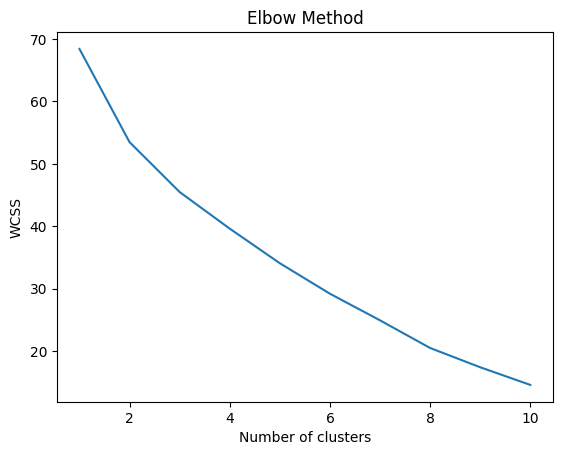

In [9]:
# Calculate the WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(job_postings_vectors_bert)
    wcss.append(kmeans.inertia_)

# Plot the WCSS against the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In the **Elbow Method** graph, as the number of clusters increases, the WCSS will decrease, but at a certain point, the decrease will start to slow down. This point is called the elbow, and it is usually considered to be the optimal number of clusters. The elbow point represents the optimal number of clusters in K-means by identifying where the Within-Cluster Sum of Squares starts to level off. In this case, it can be easily seen that 2, 4 and 6 are considered to be the 'elbow points'.

We chose 4 as 2 is quite underfitting.

In [10]:
# There are 3 "elbows" at 2, 4 and 6 clusters. 
# We chose 4, since 2 is too general and 6 has a smaller "elbow"

# Initialize the k-means model
n_clusters = 4 
kmeans_model_job = KMeans(n_clusters=n_clusters, random_state=20)

# Fit the model and predict clusters
job_postings_clusters = kmeans_model_job.fit_predict(job_postings_vectors_bert)

# Get labels for each cluster
df_translated_job['kmean_model_output'] = kmeans_model_job.labels_

# Print the output of the k-means model
df_translated_job.head()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Title,Job description,Requirements,Merged,kmean_model_output
0,apprenticeship as a sales assistant retail cle...,with the knowledge you have acquired you will ...,you have a high school diploma and are interes...,apprenticeship sales assistant retail clerk ed...,1
1,apprenticeship as a salesperson for the food t...,you will learn how to expertly serve our custo...,you have a high school diploma and you are awa...,apprenticeship salesperson food trade bakery e...,2
2,apprenticeship as a specialist salesperson for...,we will teach you how to properly process care...,you have a high school diploma and you are awa...,apprenticeship specialist salesperson food tra...,2
3,integrated retail specialist training edeka markt,you plan and organize the sale you procure goo...,higher education entrance qualification is a p...,integrated retail specialist training edeka ma...,1
4,sales assistant cashier edeka treugut,they advise and serve our customers and also s...,a completed apprenticeship in retail eg retail...,sales assistant cashier edeka treugut advise s...,1


After running K-means clustering on the job postings with 4 clusters, we assign a label to each cluster. Please note that the labels are mostly generated based on domain knowledge. It can be improved if we have more business context.

In [11]:
# Group the captions by cluster
grouped_job = df_translated_job.groupby('kmean_model_output')['Merged'].apply(' '.join).reset_index()

# Create a dictionary of cluster labels
cluster_label_dict = {
    0: 'baked food, bakery, customer service, business, technology',
    1: 'retail sales inventory product management customer service checkout clean store sales',
    2: 'food apprenticeship sales supermarket',
    3: 'teamwork training management decision quality customer',
}

# Map the labels to the clusters
df_translated_job['job_topic'] = df_translated_job['kmean_model_output'].map(cluster_label_dict)

## D. Topic Modelling: Instagram Profiles

For the Instagram dataset, we followed a similar approach to the one we used for job postings, clustering data using K-means algorithm. We calculate the WCSS of the elbow method for different numbers of clusters to find the optimal number of clusters.

In [12]:
# Read the data and save as insta_postings_vectors_bert
instagram_postings_vectors_bert = pd.read_pickle("Datasets/bert_instagram_postings_vectors.pkl")

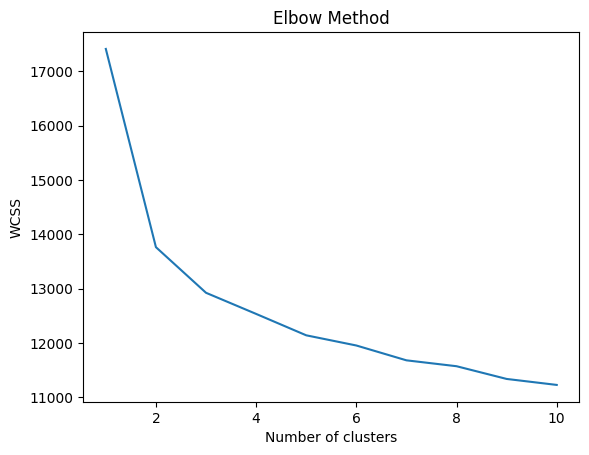

In [13]:
# Calculate the WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(instagram_postings_vectors_bert)
    wcss.append(kmeans.inertia_)

# Plot the WCSS against the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Analyzing the elbow points from the graph, we notice that the optimal number of clusters for the Instagram dataset would be 2. However, considering a diverse dataset such as Instagram data (filled with many topics and themes), 2 clusters / topics will not give us much insights.

We decided to choose 10 specifically for this case, although 10 might result in our model's overfitting (according to the Elbow graph) because it will give us as well as MatchBrand better insights into their influencer pool, not only for the matching purpose but potential improvement for their product. Moreover, a K-means model with 10 clusters gives us the most well-defined topics and eases off the topic labeling process.

In [14]:
# We choose 10 cluster as an optimal number
n_clusters = 10
kmeans_model_insta = KMeans(n_clusters=n_clusters, random_state=20)

# Fit the model to the data
kmeans_model_insta.fit(instagram_postings_vectors_bert)

# Predict clusters
instagram_captions_clusters = kmeans_model_insta.predict(instagram_postings_vectors_bert)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


To get topics for each cluster in the Instagram dataset, we tried different methods:

- Examine WordCloud

- Examine Cluster centroids

- Manual labeling based on domain knowledge

In [15]:
# Get labels for each cluster
df_translated_insta['cluster'] = kmeans_model_insta.labels_

# Print the output of the k-means model
df_translated_insta

,caption,ownerId,ownerUsername,cluster
0,roasted garlic butter butter garlic butter foo...,195942622,may jolina,6
2,neon,195942622,may jolina,1
4,reconstructive behaviour avoid pain knowing ba...,195942622,may jolina,8
6,cyprus,201993634,karlikartell,1
7,cyprus,201993634,karlikartell,1
...,...,...,...,...
1030,style,212037638,jonas.ju,1
1032,beamer benz bentley,212037638,jonas.ju,7
1033,check job,212037638,jonas.ju,5
1035,swish,212037638,jonas.ju,5


In [16]:
# Group the captions by cluster
grouped_captions = df_translated_insta.groupby('cluster')['caption'].apply(' '.join).reset_index()

In [17]:
# Drop cluster 8
grouped_captions = grouped_captions.drop([8])

In [18]:
# Delete words with less than 2 characters
grouped_captions['caption'] = grouped_captions['caption'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


#### WordCloud

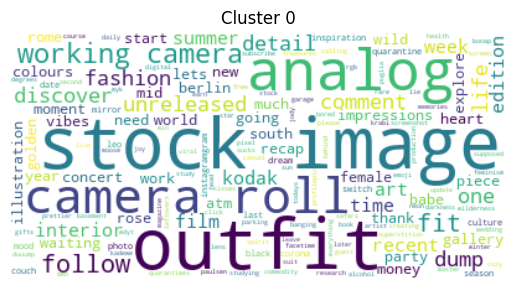

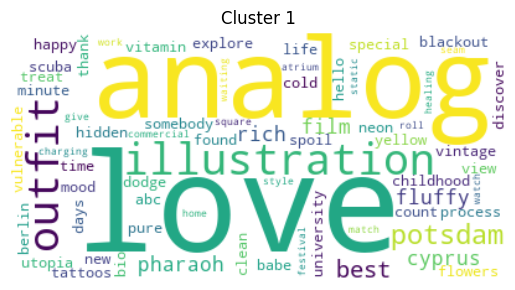

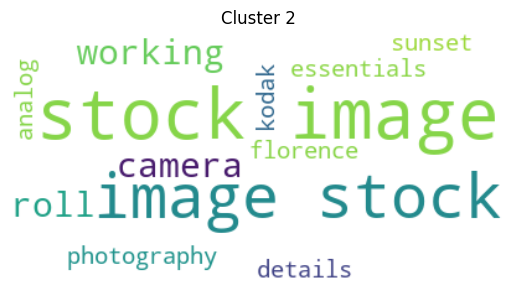

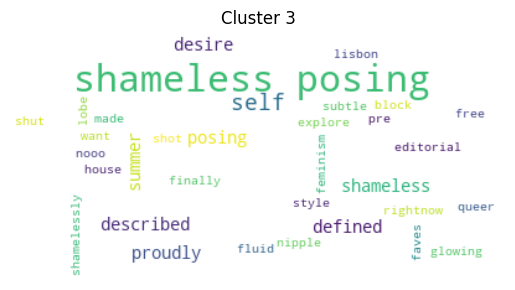

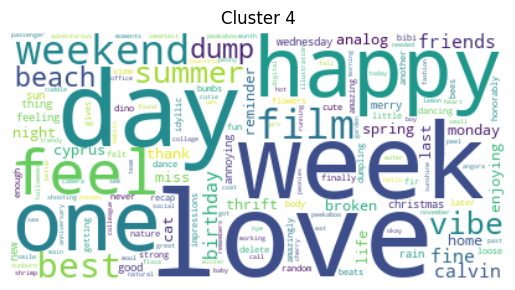

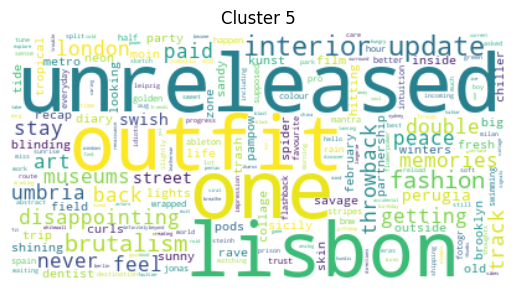

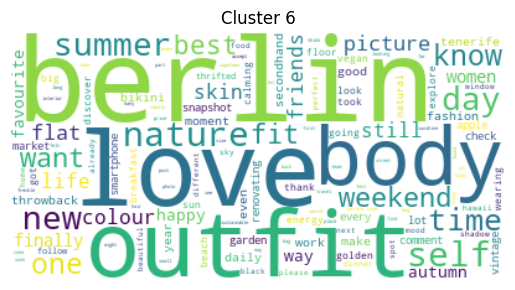

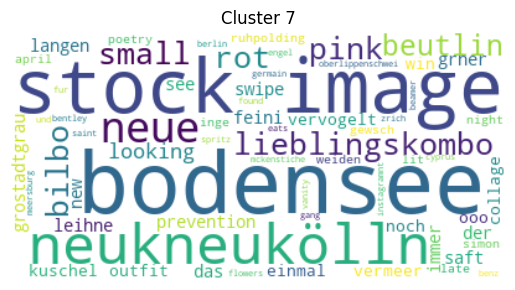

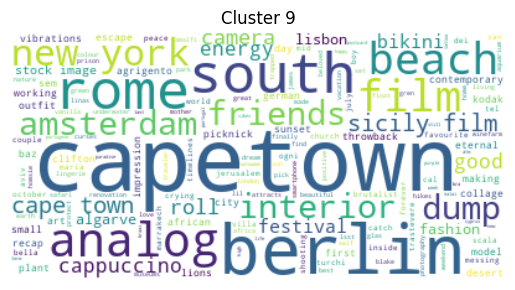

In [19]:
# Define loop for Wordcloud
for i, group in grouped_captions.iterrows():
    # Generate Wordcloud
    wordcloud = WordCloud(background_color='white').generate(group['caption'])
    
    # Display the Wordcloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {group["cluster"]}')
    plt.show()

In [20]:
# save to csv
# grouped_captions.to_csv('Datasets/grouped_captions.csv', index=False)

#### Cluster Centroids

In [21]:
# Initialise transformer 
vec_tf=TfidfVectorizer(max_df=0.7, min_df=0.1)

# Apply the tfidf transformer
data_tfidf = vec_tf.fit_transform(grouped_captions['caption'])

# Store the feature names
words = vec_tf.get_feature_names_out()

# For each cluster, print the ten words of its centroid with the highest tf-idf frequencies 
common_words = kmeans_model_insta.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : balk, andrs, fast, cameraroll, expensive, dinner, find, current, differences, arts
1 : body, everypieceisthrifted, balk, freedom, beam, everything, facetime, fast, current, cameraroll
2 : body, balk, everypieceisthrifted, andrs, ecstasy, facetime, care, cameraroll, fast, coat
3 : body, balk, expensive, anymore, bureaucracy, declared, beam, arles, current, gaze
4 : fast, body, balk, current, expensive, cameraroll, andrs, bibi, case, dress
5 : body, balk, everypieceisthrifted, cameraroll, fast, current, freedom, expensive, elegant, facetime
6 : find, balk, andrs, colours, bibi, fast, breakfasts, arts, differences, case
7 : balk, cameraroll, fast, fear, breakfasts, declared, explorepage, body, feed, germain
8 : andrs, find, balk, colours, fast, bibi, differences, arles, case, current
9 : balk, expensive, fast, breakfasts, andrs, cameraroll, bibi, differences, current, find


#### Manual Labeling

In [22]:
# Create a dictionary of cluster labels based on cluster centroids
cluster_label_dict = {
    0: 'Stock Image and Photography, Thrifting and Fashion, Enjoying Life',
    1: 'Love for Berlin and fashion',
    2: 'Life in Berlin, Apartment and Home',
    3: 'Traveling and Vacationing',
    4: 'Analog Photography',
    5: 'Shameless Posing, humor, fun, and self-love',
    6: 'Outfits, Secondhand Fashion, Recycling, Sustainability and Style',
    7: 'Film, Photography, and Art',
    8: 'Random',
    9: 'Chill and soothing vibes, Mental Health',
}

# Map the labels to the clusters
df_translated_insta['insta_topic'] = df_translated_insta['cluster'].map(cluster_label_dict)

In [23]:
# Group by 'label' and 'ownerUsername' and count posts
df_counts = df_translated_insta.groupby(['insta_topic', 'ownerUsername']).size().reset_index(name='counts')

# Sort by 'label' and 'counts'
df_sorted = df_counts.sort_values(['insta_topic', 'counts'], ascending=[True, False])

# Group by 'label' and join 'ownerUsername' into one cell (preserving order)
df_grouped = df_sorted.groupby('insta_topic')['ownerUsername'].apply(', '.join).reset_index()

# For each unique label in the sorted DataFrame
for label in df_grouped['insta_topic'].unique():
    print(f'{label}:')
    
    # Filter DataFrame for current label
    df_label = df_sorted[df_sorted['insta_topic'] == label]
    
    # Enumerate over rows in filtered DataFrame, adding 1 to index for 1-based numbering
    for i, row in enumerate(df_label.itertuples(), 1):
        print(f'{i}. {row.ownerUsername}, {row.counts}')
        
    print('\n')

Analog Photography:
1. karlikartell, 34
2. stones, 21
3. may jolina, 20
4. jonas.ju, 17
5. toxicorny, 10
6. nele.tuech, 3


Chill and soothing vibes, Mental Health:
1. may jolina, 27
2. nele.tuech, 16
3. karlikartell, 12
4. stones, 4
5. jonas.ju, 2
6. johannarhr, 1
7. toxicorny, 1


Film, Photography, and Art:
1. karlikartell, 9
2. nele.tuech, 8
3. jonas.ju, 5
4. stones, 2
5. toxicorny, 2


Life in Berlin, Apartment and Home:
1. nele.tuech, 36
2. may jolina, 1


Love for Berlin and fashion:
1. jonas.ju, 28
2. karlikartell, 17
3. stones, 16
4. may jolina, 15
5. toxicorny, 11
6. nele.tuech, 4


Outfits, Secondhand Fashion, Recycling, Sustainability and Style:
1. stones, 48
2. karlikartell, 33
3. nele.tuech, 28
4. may jolina, 23
5. jonas.ju, 4
6. toxicorny, 2


Random:
1. may jolina, 36
2. nele.tuech, 35
3. karlikartell, 25
4. stones, 11
5. toxicorny, 2
6. bumble_de, 1
7. jonas.ju, 1


Shameless Posing, humor, fun, and self-love:
1. jonas.ju, 39
2. karlikartell, 26
3. may jolina, 21
4. st

## E. Matching Instagram profiles with job postings
We leveraged cosine similarity to be the main factor in the matching score.

### Data Preparation

In [24]:
# Iterate through rows of df_grouped
for _, row in df_grouped.iterrows():
    insta_topic = row['insta_topic']
    usernames = row['ownerUsername'].split(', ')
    
    # Print insta_topic
    print(f'Insta Topic: {insta_topic}\n')
    
    # Iterate through usernames
    for username in usernames:
        influencer_posts = df_translated_insta[(df_translated_insta['insta_topic'] == insta_topic) & (df_translated_insta['ownerUsername'] == username)]
        posts_text = influencer_posts['caption'].tolist()
        
        #print(f'Username: {username}')
        #print('\n'.join(posts_text))
        #print('---\n')

Insta Topic: Analog Photography

Insta Topic: Chill and soothing vibes, Mental Health

Insta Topic: Film, Photography, and Art

Insta Topic: Life in Berlin, Apartment and Home

Insta Topic: Love for Berlin and fashion

Insta Topic: Outfits, Secondhand Fashion, Recycling, Sustainability and Style

Insta Topic: Random

Insta Topic: Shameless Posing, humor, fun, and self-love

Insta Topic: Stock Image and Photography, Thrifting and Fashion, Enjoying Life

Insta Topic: Traveling and Vacationing



In [25]:
# Initilaize emplty list to store the data
data = []

# Iterate through each row of the grouped DataFrame
for _, row in df_grouped.iterrows():
    insta_topic = row['insta_topic']
    usernames = row['ownerUsername'].split(', ')
    
    # Iterate through each username
    for username in usernames:
        influencer_posts = df_translated_insta[(df_translated_insta['insta_topic'] == insta_topic) & (df_translated_insta['ownerUsername'] == username)]
        posts_text = influencer_posts['caption'].tolist()
        
        merged_posts_text = ' '.join(posts_text)  # join all the captions into one string
        num_captions = len(posts_text)  # count the number of captions

        # append the information to the data list
        data.append({
            'insta_topic': insta_topic,
            'username': username,
            'merged_text': merged_posts_text,
            'num_captions': num_captions
        })

# convert the data list into a DataFrame
df_subtopic = pd.DataFrame(data)

### Matching
 The matching will be conducted between the job topics and instagram topics (which contains the influencers)

In [26]:
# Use DistilBERT model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Compute embeddings for Instagram Labels and Job labels (Matching the topics)
insta_embeddings = model.encode(df_grouped['insta_topic'].tolist())
job_embeddings = model.encode(df_translated_job['job_topic'].tolist())

# Compute cosine similarity
cosine_similarities = cosine_similarity(insta_embeddings, job_embeddings)

In [27]:
# Get the indices of the most similar job labels for each Instagram caption
most_similar_indices = np.argmax(cosine_similarities, axis=1)

# Get the most similar job labels
most_similar_labels = df_translated_job['job_topic'].iloc[most_similar_indices]

# Add the most similar job labels to your Instagram data
df_grouped['job_topic'] = most_similar_labels.values

df_grouped

,insta_topic,ownerUsername,job_topic
0,Analog Photography,"karlikartell, stones, may jolina, jonas.ju, to...",teamwork training management decision quality ...
1,"Chill and soothing vibes, Mental Health","may jolina, nele.tuech, karlikartell, stones, ...",retail sales inventory product management cust...
2,"Film, Photography, and Art","karlikartell, nele.tuech, jonas.ju, stones, to...",teamwork training management decision quality ...
3,"Life in Berlin, Apartment and Home","nele.tuech, may jolina","baked food, bakery, customer service, business..."
4,Love for Berlin and fashion,"jonas.ju, karlikartell, stones, may jolina, to...",retail sales inventory product management cust...
5,"Outfits, Secondhand Fashion, Recycling, Sustai...","stones, karlikartell, nele.tuech, may jolina, ...","baked food, bakery, customer service, business..."
6,Random,"may jolina, nele.tuech, karlikartell, stones, ...",retail sales inventory product management cust...
7,"Shameless Posing, humor, fun, and self-love","jonas.ju, karlikartell, may jolina, stones, to...",teamwork training management decision quality ...
8,"Stock Image and Photography, Thrifting and Fas...","karlikartell, nele.tuech, may jolina, jonas.ju...",retail sales inventory product management cust...
9,Traveling and Vacationing,"nele.tuech, may jolina, karlikartell",teamwork training management decision quality ...


In [28]:
# Load original Job postings data from Excel file
df_job =  pd.read_excel('Datasets/dataset_hwr_job_posting.xlsx')

# Merge the Instagram and Job data
df_merged = df_grouped.merge(df_translated_job, on='job_topic', how='inner')
df_matching = pd.DataFrame()
df_matching['Company'] = df_job['Company']
df_matching['Job Title DE'] = df_job['Title']
df_matching['Instagram Account'] = df_merged['ownerUsername']
df_matching['Instagram Topic'] = df_merged['insta_topic']

In [29]:
# First, create a new dataframe where each row corresponds to an unique user
user_post_counts = df_subtopic.groupby(['username', 'insta_topic'])['num_captions'].sum().reset_index()

# rename 'num_captions' column to 'number_of_posts'
user_post_counts = user_post_counts.rename(columns={'num_captions': 'number_of_posts'})

# 'Instagram Account' in df_final_matching is a string of usernames separated by comma
# So, we need to split this column into a list of usernames

# Split 'Instagram Account' into a list of accounts
df_matching['Instagram Account'] = df_matching['Instagram Account'].str.split(', ')

# Now let's explode 'Instagram Account' so that each row corresponds to a unique account and job title
df_matching = df_matching.explode('Instagram Account')

# Now, merge df_final_matching with user_post_counts
df_matching = pd.merge(df_matching, user_post_counts, how='left', 
                             left_on=['Instagram Account', 'Instagram Topic'], 
                             right_on=['username', 'insta_topic'])

df_matching.head()

,Company,Job Title DE,Instagram Account,Instagram Topic,username,insta_topic,number_of_posts
0,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,karlikartell,Analog Photography,karlikartell,Analog Photography,34
1,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,stones,Analog Photography,stones,Analog Photography,21
2,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,may jolina,Analog Photography,may jolina,Analog Photography,20
3,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,jonas.ju,Analog Photography,jonas.ju,Analog Photography,17
4,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,toxicorny,Analog Photography,toxicorny,Analog Photography,10


In [30]:
# Group by 'Job Title DE' and 'Instagram Topic', 
# then aggregate 'Instagram Account' and 'number_of_posts' into comma-separated strings
df_final_matching = df_matching.groupby(['Company', 'Job Title DE', 'Instagram Topic']).agg({
    'Instagram Account': ', '.join,
    'number_of_posts': lambda x: ', '.join(map(str, x))
}).reset_index()

# Merge the two DataFrames on the relevant columns
df_final = pd.merge(df_final_matching, df_subtopic,  how='left', left_on=['Instagram Account','Job Title DE'], right_on = ['username','insta_topic'])

# Compute the cosine similarity again to get matching score for each pair
cosine_similarities = cosine_similarity(job_postings_vectors_bert, instagram_postings_vectors_bert)
matching_scores = np.max(cosine_similarities, axis=1)

# Add the matching score to the DataFrame
df_final['topic_matching_score'] = matching_scores

The **total_score** consists of two parts. The first part consists of the multiplication between the topic_matching_score and defined weight of 0.9.
The second part is composed of the multiplication between the proportion_of_posts and the defined weight of 0.1, where

* **topic_matching_score** == the result of the cosine similarity between the instagram and job topics with values ranging between -1 and 1. The value "1" represents the perfect similarity, while "-1" is the worst one.

* **proportion_of_posts** == the ratio of the number of posts by a specific influencer on a particular topic to the total number of posts on the same topic by all influencers.

The closer the score to 1 the better is the match.

In practice, this matching score can be improved significantly by incorporating real world outcomes (e.g. if candidates really apply for the jobs or even if they get hired in the end) in the dataset to improve and evaluate the model predictions.

In [31]:
# Drop uneeded columns
df_final = df_final.drop(['insta_topic', 'username', 'merged_text', 'num_captions'], axis=1)

# Split the 'number_of_posts' column by comma delimiter and convert the values to a list
df_final['number_of_posts'] = df_final['number_of_posts'].str.split(',')

# Convert the 'topic_matching_score' column to numeric
df_final['topic_matching_score'] = pd.to_numeric(df_final['topic_matching_score'])

# Convert the 'number_of_posts' list to integers
df_final['number_of_posts'] = df_final['number_of_posts'].apply(lambda x: list(map(int, x)))

# Calculate the total number of posts for each job
df_final['total_posts'] = df_final['number_of_posts'].apply(sum)

# Compute the proportion of posts per job
df_final['proportion_of_posts'] = df_final.apply(lambda row: [post/row['total_posts'] for post in row['number_of_posts']], axis=1)

# Define weights
weight_proportion_of_posts = 0.1
weight_topic_matching_score = 0.9

# Calculate total score using the proportion of posts and topic_matching_score
df_final['total_score'] = df_final.apply(lambda row: [round(row['topic_matching_score'] * weight_topic_matching_score + weight_proportion_of_posts * proportion, 2) for proportion in row['proportion_of_posts']], axis=1)

# Round the values in the 'topic_matching_score' and 'proportion_of_posts' columns to 2 decimal places
df_final['topic_matching_score'] = df_final['topic_matching_score'].apply(lambda x: round(x, 2))
df_final['proportion_of_posts'] = df_final['proportion_of_posts'].apply(lambda x: [round(proportion, 2) for proportion in x])

df_final

,Company,Job Title DE,Instagram Topic,Instagram Account,number_of_posts,topic_matching_score,total_posts,proportion_of_posts,total_score
0,Bosch,Developer for Embedded Linux (f/m/div.),"Chill and soothing vibes, Mental Health","may jolina, nele.tuech, karlikartell, stones, ...","[27, 16, 12, 4, 2, 1, 1]",0.88,63,"[0.43, 0.25, 0.19, 0.06, 0.03, 0.02, 0.02]","[0.84, 0.82, 0.81, 0.8, 0.8, 0.8, 0.8]"
1,Buying Labs GmbH,Werkstudent/in Buying (m/w/d) Luxury / Premium...,"Chill and soothing vibes, Mental Health","may jolina, nele.tuech, karlikartell, stones, ...","[27, 16, 12, 4, 2, 1, 1]",0.90,63,"[0.43, 0.25, 0.19, 0.06, 0.03, 0.02, 0.02]","[0.85, 0.83, 0.83, 0.82, 0.81, 0.81, 0.81]"
2,Edeka,Ausbildung Fachverkäuferin Lebensmittelhandwer...,Analog Photography,"karlikartell, stones, may jolina, jonas.ju, to...","[34, 21, 20, 17, 10, 3]",0.90,105,"[0.32, 0.2, 0.19, 0.16, 0.1, 0.03]","[0.85, 0.83, 0.83, 0.83, 0.82, 0.82]"
3,Edeka,Ausbildung Fachverkäuferin Lebensmittelhandwer...,"Film, Photography, and Art","karlikartell, nele.tuech, jonas.ju, stones, to...","[9, 8, 5, 2, 2]",0.86,26,"[0.35, 0.31, 0.19, 0.08, 0.08]","[0.81, 0.8, 0.79, 0.78, 0.78]"
4,Edeka,Ausbildung Handelsfachwirtin integriert (m/w/d...,"Film, Photography, and Art","karlikartell, nele.tuech, jonas.ju, stones, to...","[9, 8, 5, 2, 2]",0.92,26,"[0.35, 0.31, 0.19, 0.08, 0.08]","[0.86, 0.86, 0.84, 0.83, 0.83]"
5,Edeka,Ausbildung Verkäuferin (m/w/d) / Kauffrau im E...,Analog Photography,"karlikartell, stones, may jolina, jonas.ju, to...","[34, 21, 20, 17, 10, 3]",0.92,105,"[0.32, 0.2, 0.19, 0.16, 0.1, 0.03]","[0.86, 0.85, 0.85, 0.85, 0.84, 0.83]"
6,Edeka,Backwaren-Liebhaberin (m/w/d),"Shameless Posing, humor, fun, and self-love","jonas.ju, karlikartell, may jolina, stones, to...","[39, 26, 21, 18, 17, 11]",0.90,132,"[0.3, 0.2, 0.16, 0.14, 0.13, 0.08]","[0.84, 0.83, 0.83, 0.82, 0.82, 0.82]"
7,Edeka,Stellvertretende Marktleitung (m/w/d) EDEKA Ci...,Traveling and Vacationing,"nele.tuech, may jolina, karlikartell","[25, 3, 2]",0.85,30,"[0.83, 0.1, 0.07]","[0.85, 0.77, 0.77]"
8,Edeka,Verkäuferin / Kassiererin (m/w/d) EDEKA Treugut,"Shameless Posing, humor, fun, and self-love","jonas.ju, karlikartell, may jolina, stones, to...","[39, 26, 21, 18, 17, 11]",0.86,132,"[0.3, 0.2, 0.16, 0.14, 0.13, 0.08]","[0.81, 0.8, 0.79, 0.79, 0.79, 0.79]"
9,Ernsting’s family,Trainee Fashion Management,"Chill and soothing vibes, Mental Health","may jolina, nele.tuech, karlikartell, stones, ...","[27, 16, 12, 4, 2, 1, 1]",0.88,63,"[0.43, 0.25, 0.19, 0.06, 0.03, 0.02, 0.02]","[0.83, 0.82, 0.81, 0.8, 0.8, 0.79, 0.79]"


In [32]:
# Convert 'Instagram Account', 'number_of_posts', 'proportion_of_posts', and 'total_score' from string back to list
df_final['Instagram Account'] = df_final['Instagram Account'].str.split(', ')
df_final['number_of_posts'] = df_final['number_of_posts'].apply(lambda x: [int(i) for i in x])
df_final['proportion_of_posts'] = df_final['proportion_of_posts'].apply(lambda x: [float(i) for i in x])
df_final['total_score'] = df_final['total_score'].apply(lambda x: [float(i) for i in x])

# Create an empty DataFrame
df_final_expanded = pd.DataFrame()

# Loop through each row of df_final
for idx, row in df_final.iterrows():
    # Get the first 3 Instagram Accounts, number_of_posts, proportion_of_posts and total_score
    for i in range(3):
        try:
            instagram_account = row['Instagram Account'][i]
            number_of_posts = row['number_of_posts'][i]
            proportion_of_posts = row['proportion_of_posts'][i]
            total_score = row['total_score'][i]
            
            # Append this data to the new DataFrame
            new_row = pd.DataFrame({
                'Company': [row['Company']],
                'Job Title DE': [row['Job Title DE']],
                'Instagram Topic': [row['Instagram Topic']],
                'Instagram Account': [instagram_account],
                'number_of_posts': [number_of_posts],
                'topic_matching_score': [row['topic_matching_score']],
                'total_posts': [row['total_posts']],
                'proportion_of_posts': [proportion_of_posts],
                'total_score': [total_score]
            })
            
            df_final_expanded = pd.concat([df_final_expanded, new_row], ignore_index=True)
        except IndexError:
            # This handles cases where there are less than 3 Instagram accounts for a job
            continue

In [33]:
# print all available job titles
print(df_final_expanded['Job Title DE'].unique())

['Developer for Embedded Linux (f/m/div.)'
 'Werkstudent/in Buying (m/w/d) Luxury / Premium Fashion'
 'Ausbildung Fachverkäuferin Lebensmittelhandwerk - Bäckerei (m/w/d) EDEKA Center - 2023'
 'Ausbildung Fachverkäuferin Lebensmittelhandwerk - Fleischerei (m/w/d) EDEKA Markt - 2023'
 'Ausbildung Handelsfachwirtin integriert (m/w/d) EDEKA Markt - 2023'
 'Ausbildung Verkäuferin (m/w/d) / Kauffrau im Einzelhandel (m/w/d) EDEKA Markt - 2023'
 'Backwaren-Liebhaberin (m/w/d)'
 'Stellvertretende Marktleitung (m/w/d) EDEKA City Markt'
 'Verkäuferin / Kassiererin (m/w/d) EDEKA Treugut'
 'Trainee Fashion Management' 'Verkäufer (m/w/d) Modebranche'
 'Software Engineer - Python'
 'Developer MS Dynamics 365 Business Central / NAV (m/w/d)'
 'Senior Python Developer (f/m/d)'
 'Praktikum Merchandising & Produktentwicklung (fashion/apparel)'
 'Fashion Consultant (m/w/d)']


In [34]:
# Print samples of the final results with the top 3 best matches
#df_final_expanded[(df_final_expanded['Job Title DE'] == 'Trainee Fashion Management') | (df_final_expanded['Job Title DE'] == 'Fashion Consultant (m/w/d)')]
df_final_expanded[(df_final_expanded['Job Title DE'] == 'Trainee Fashion Management')]

,Company,Job Title DE,Instagram Topic,Instagram Account,number_of_posts,topic_matching_score,total_posts,proportion_of_posts,total_score
27,Ernsting’s family,Trainee Fashion Management,"Chill and soothing vibes, Mental Health",may jolina,27,0.88,63,0.43,0.83
28,Ernsting’s family,Trainee Fashion Management,"Chill and soothing vibes, Mental Health",nele.tuech,16,0.88,63,0.25,0.82
29,Ernsting’s family,Trainee Fashion Management,"Chill and soothing vibes, Mental Health",karlikartell,12,0.88,63,0.19,0.81
